In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import warnings
import sys
#warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))

Geopandas has version 0.13.2


In [2]:
# add paths for modules
sys.path.append('../src/visualization')
sys.path.append('../src/features')
print(sys.path)

# import modules
import visualize

['/Users/janhendrikwebert/maritime_route_prediction/notebooks', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../src/visualization', '../src/features']


In [3]:
# read data from file
filename = '../data/raw/AIS_04-09_2022_stavanger/ais_202204.csv'
df = pd.read_csv(filename, delimiter=';', decimal='.')
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13207658 entries, 0 to 13207657
Data columns (total 11 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   mmsi           13207658 non-null  int64  
 1   imo_nr         13207658 non-null  int64  
 2   length         13207658 non-null  int64  
 3   date_time_utc  13207658 non-null  object 
 4   lon            13207658 non-null  float64
 5   lat            13207658 non-null  float64
 6   sog            13207658 non-null  float64
 7   cog            13207658 non-null  float64
 8   true_heading   13207658 non-null  int64  
 9   nav_status     13207658 non-null  int64  
 10  message_nr     13207658 non-null  int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 1.1+ GB


In [4]:
# convert to geopandas df
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
df = []  # free memory
n_messages = len(gdf)

In [5]:
duplicates = gdf.duplicated(subset=['mmsi', 'lat', 'lon'], keep='first')
n_duplicates = len(gdf[duplicates])

In [6]:
# drop duplicate AIS data (reported by multiple stations)
cleaned_gdf = gdf.drop_duplicates(subset = ['mmsi', 'lat', 'lon'],
                                    keep = 'first')
print(f'Dropped {n_duplicates} duplicates ({n_duplicates/n_messages*100:.2f}%)')

Dropped 6474255 duplicates (49.02%)


In [7]:
gdf.info()  # print information about loaded data

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13207658 entries, 0 to 13207657
Data columns (total 12 columns):
 #   Column         Dtype   
---  ------         -----   
 0   mmsi           int64   
 1   imo_nr         int64   
 2   length         int64   
 3   date_time_utc  object  
 4   lon            float64 
 5   lat            float64 
 6   sog            float64 
 7   cog            float64 
 8   true_heading   int64   
 9   nav_status     int64   
 10  message_nr     int64   
 11  geometry       geometry
dtypes: float64(4), geometry(1), int64(6), object(1)
memory usage: 1.2+ GB


In [8]:
gdf.head()

mmsi   imo_nr  length        date_time_utc      lon      lat   sog  \
0  209318000  9754446     131  2022-09-01 08:48:26  5.16166  58.6264  12.3   
1  209318000  9754446     131  2022-09-01 08:48:36  5.16173  58.6270  12.3   
2  209318000  9754446     131  2022-09-01 08:48:46  5.16181  58.6276  12.3   
3  209318000  9754446     131  2022-09-01 08:48:57  5.16192  58.6282  12.3   
4  209318000  9754446     131  2022-09-01 08:49:06  5.16199  58.6287  12.3   

   cog  true_heading  nav_status  message_nr                  geometry  
0  4.5            10           0           1  POINT (5.16166 58.62640)  
1  4.5            10           0           1  POINT (5.16173 58.62700)  
2  4.6            10           0           1  POINT (5.16181 58.62760)  
3  4.6            10           0           1  POINT (5.16192 58.62820)  
4  4.7            10           0           1  POINT (5.16199 58.62870)

658 unique mmsi
652 unique imo_nr
11 unique nav_status
3 unique message_nr


Unique nav_status: 
 [-99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 15]
Unique message_nr: 
 [1, 3, 18]


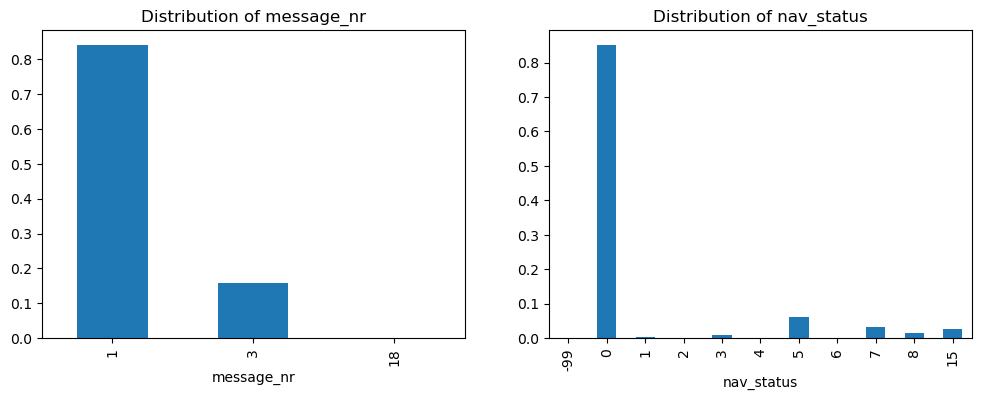

In [9]:
# some dataset characteristics
columns = ['mmsi', 'imo_nr', 'nav_status', 'message_nr']
for column in columns:
    print(f'{gdf[column].nunique()} unique {column}')

# print nav_status and message_nr values
print('\n')
print(f'Unique nav_status: \n {sorted(gdf.nav_status.unique())}')
print(f'Unique message_nr: \n {sorted(gdf.message_nr.unique())}')
msg_nr_counts = gdf['message_nr'].value_counts()
msg_nr_distribution = msg_nr_counts / len(gdf)
msg_nr_distribution = msg_nr_distribution.sort_index()
nav_status_counts = gdf['nav_status'].value_counts()
nav_status_distribution = nav_status_counts / len(gdf)
nav_status_distribution = nav_status_distribution.sort_index()

# plot ditribution of mmsi
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
msg_nr_distribution.plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of message_nr')
nav_status_distribution.plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution of nav_status')
plt.savefig('distribution of message_nr and nav_status.pdf')
plt.show()

In [10]:
# join ship metadata to get ship category distribution
sys.path.append('../src/datawrangling')
from make_trajectories_from_AIS import add_ship_metadata
metadata_filename = '../data/external/seilas-2022.csv'
gdf = add_ship_metadata(metadata_filename, gdf)

Geopandas has version 0.13.2
Movingpandas has version 0.17.1
Ship metadata has   4142 unique MMSIs
AIS raw data has    658 unique MMSIs
Overlap:            616 MMSIs


In [11]:
gdf.skipsgruppe.unique()

array(['Last', 'Passasjer', 'Tank', 'Auxiliary', 'Fisk', nan, 'Slep'],
      dtype=object)

In [12]:
gdf['skipsgruppe'] = gdf['skipsgruppe'].replace(to_replace=['Last', 'Fisk', 'Passasjer', 'Slep'], 
                                                value=['Cargo', 'Fishing', 'Passenger', 'Tug'])
gdf['skipsgruppe'].fillna('Unknown', inplace=True)

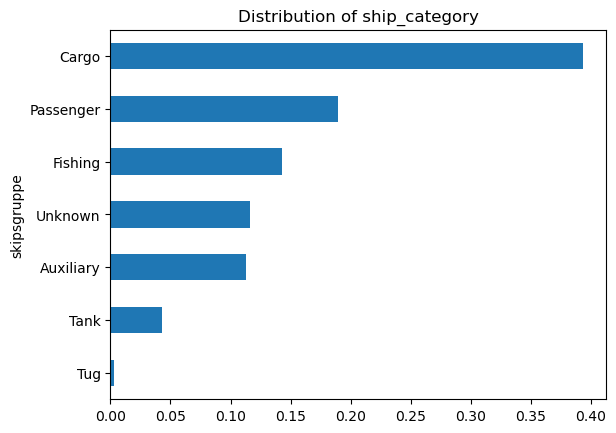

In [13]:
category_counts = gdf['skipsgruppe'].value_counts()
category_distribution = category_counts / len(gdf)
category_distribution.sort_values(inplace=True)
category_distribution.plot(kind='barh')
plt.title('Distribution of ship_category')
plt.savefig('distribution of ship_category.pdf')
plt.show()

In [14]:
mmsi = 257088660
one_ship_gdf = gdf[gdf.mmsi == mmsi]

duplicates = one_ship_gdf.duplicated(subset=['mmsi', 'lat', 'lon'], keep='first')
n_duplicates = len(one_ship_gdf[duplicates])
print(len(one_ship_gdf), n_duplicates)

150924 93099


In [15]:
print(duplicates)

119422      False
119423       True
119424       True
119425       True
119426       True
            ...  
12841284     True
12841285     True
12841286     True
12841287     True
12841288     True
Length: 150924, dtype: bool


In [16]:
# plot data (n points)
n_points = 1000  # -1 selects all points
if n_points > 0:
    # selection = np.random.randint(0, high=len(gdf), size=n_points)
    #map = gdf.iloc[0:n_points].explore(cmap='jet', column='mmsi', name='AIS messages')
    map = one_ship_gdf.iloc[0:n_points].explore(color='blue', name='AIS messages')
    map = one_ship_gdf[duplicates].iloc[0:n_points].explore(m=map, color='red', name='duplicates')
else:
    map = gdf.explore(cmap='jet', column='mmsi', name='AIS messages')

In [17]:
# get a bounding box of the geographic area
bbox = visualize.get_bounding_box(gdf)
map = bbox.explore(m=map, color='red', name='bounds')
folium.LayerControl().add_to(map)
map


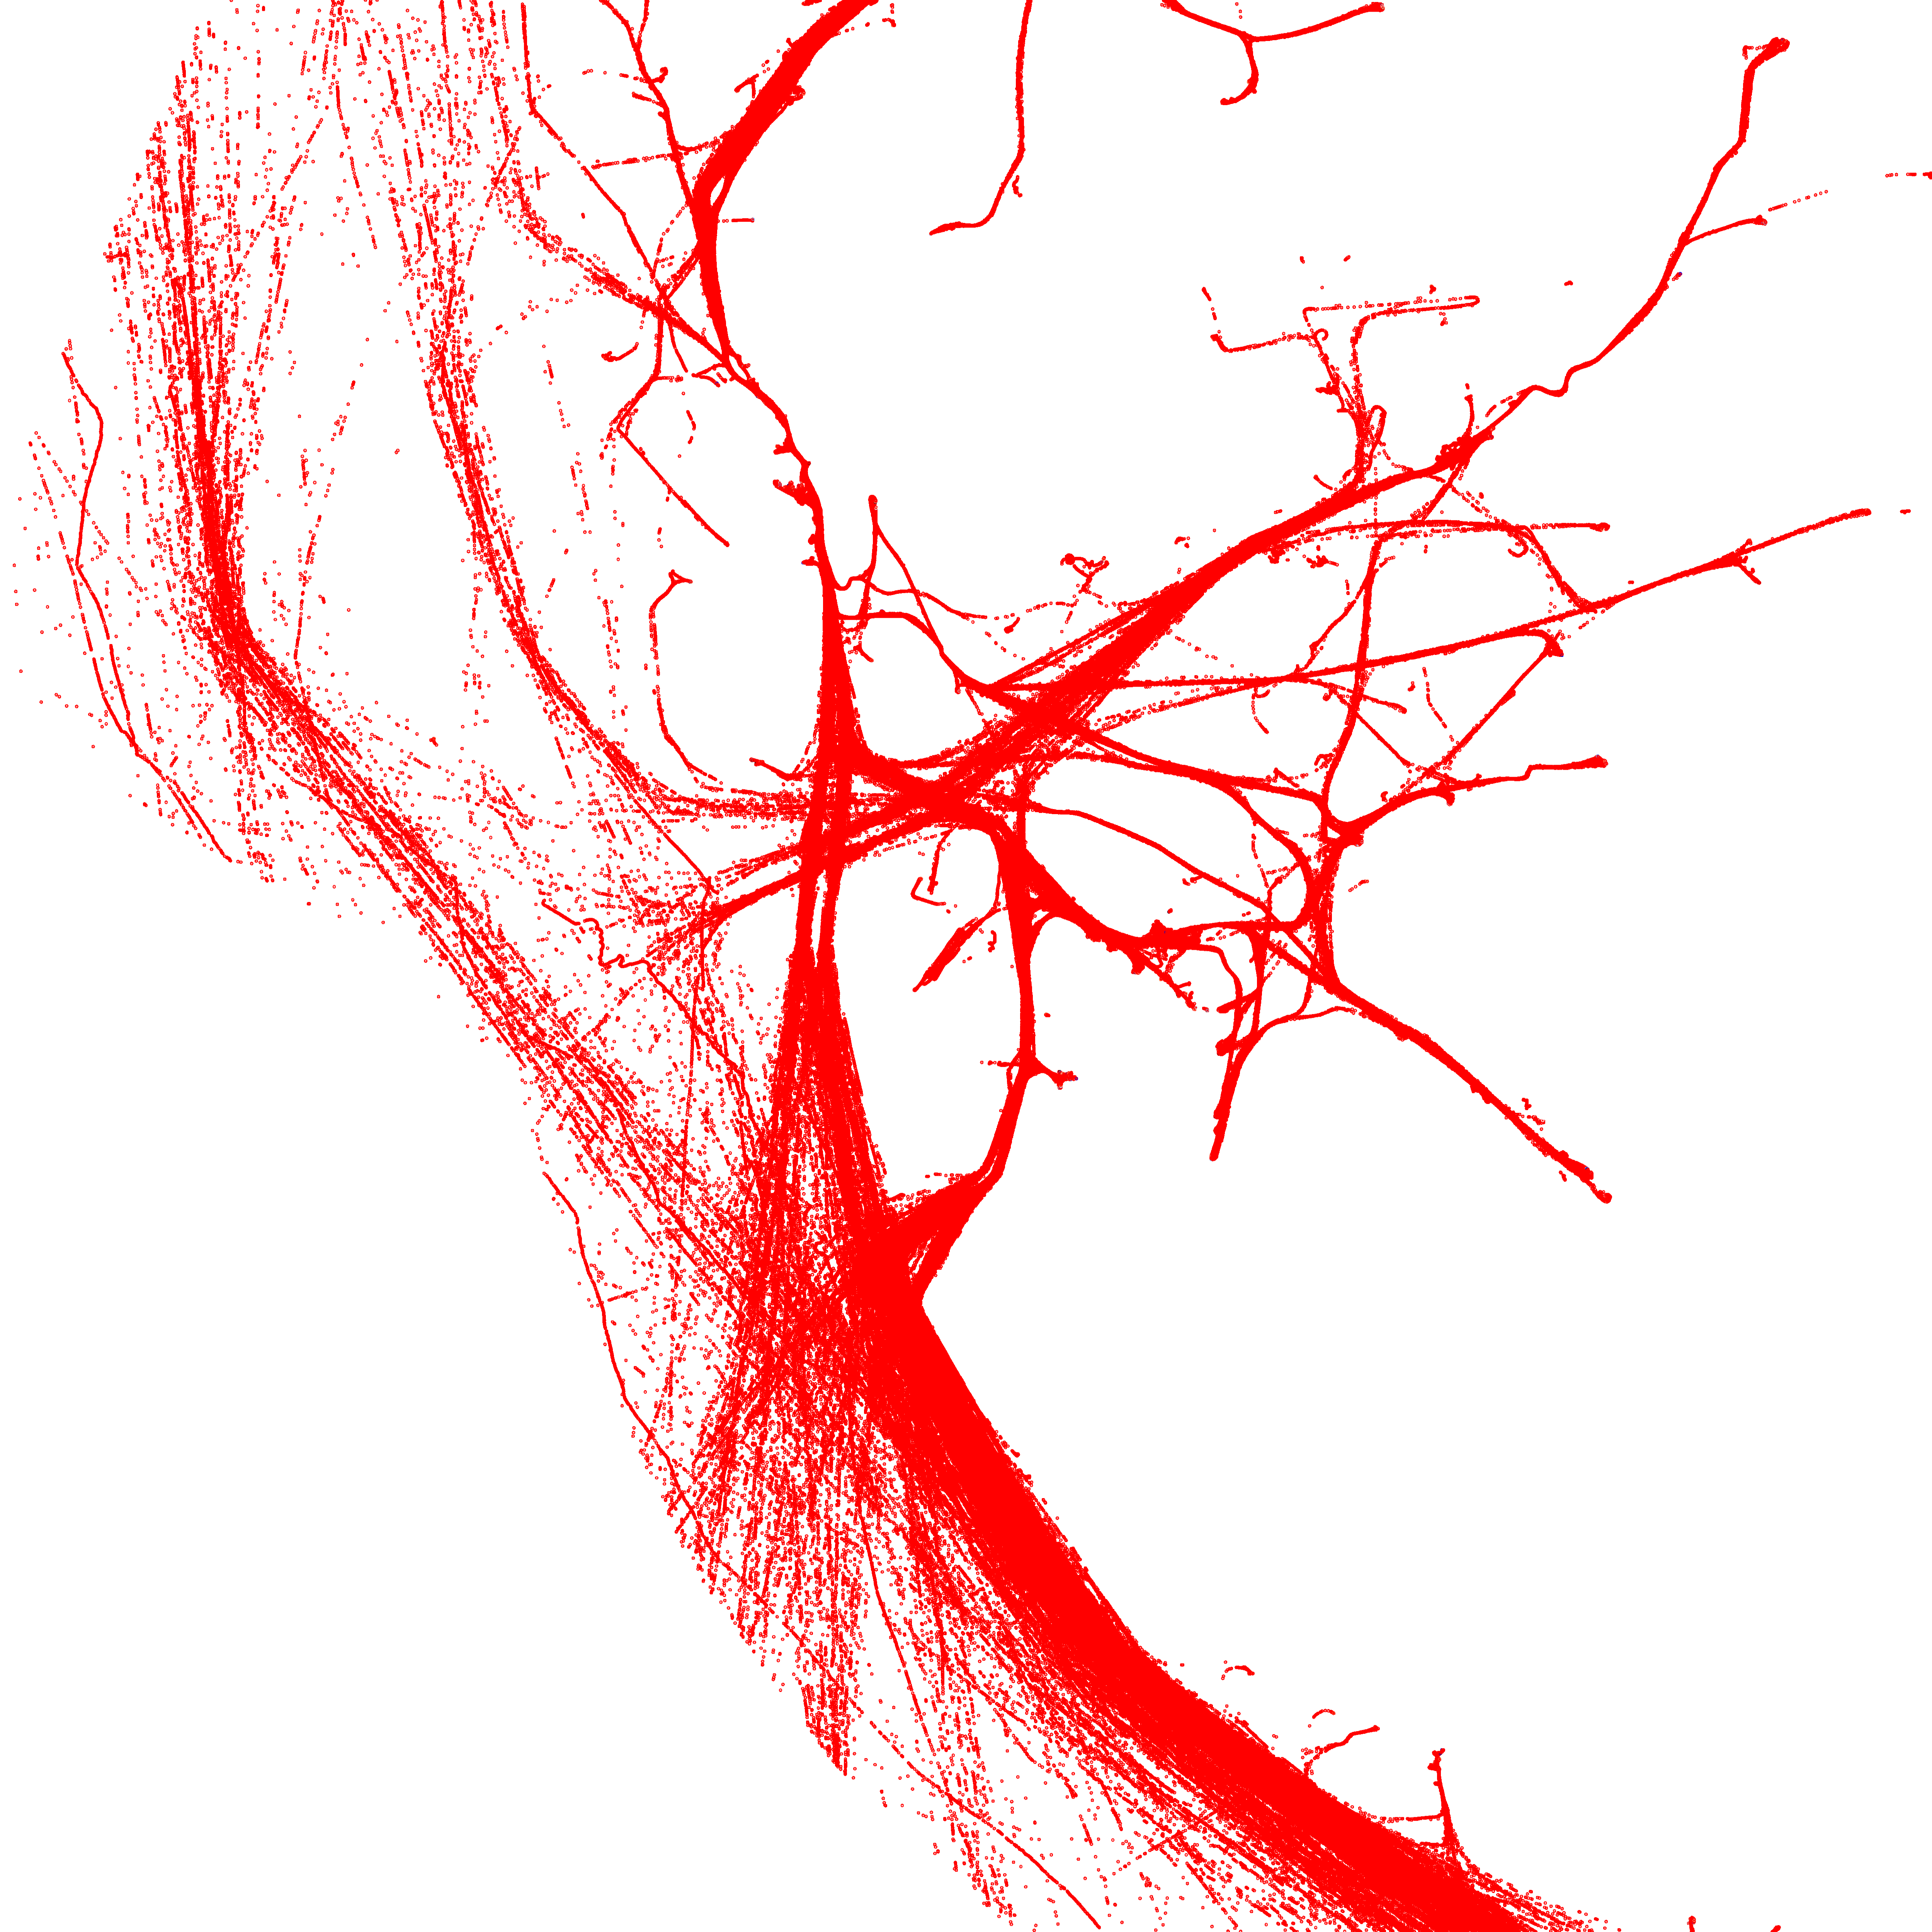
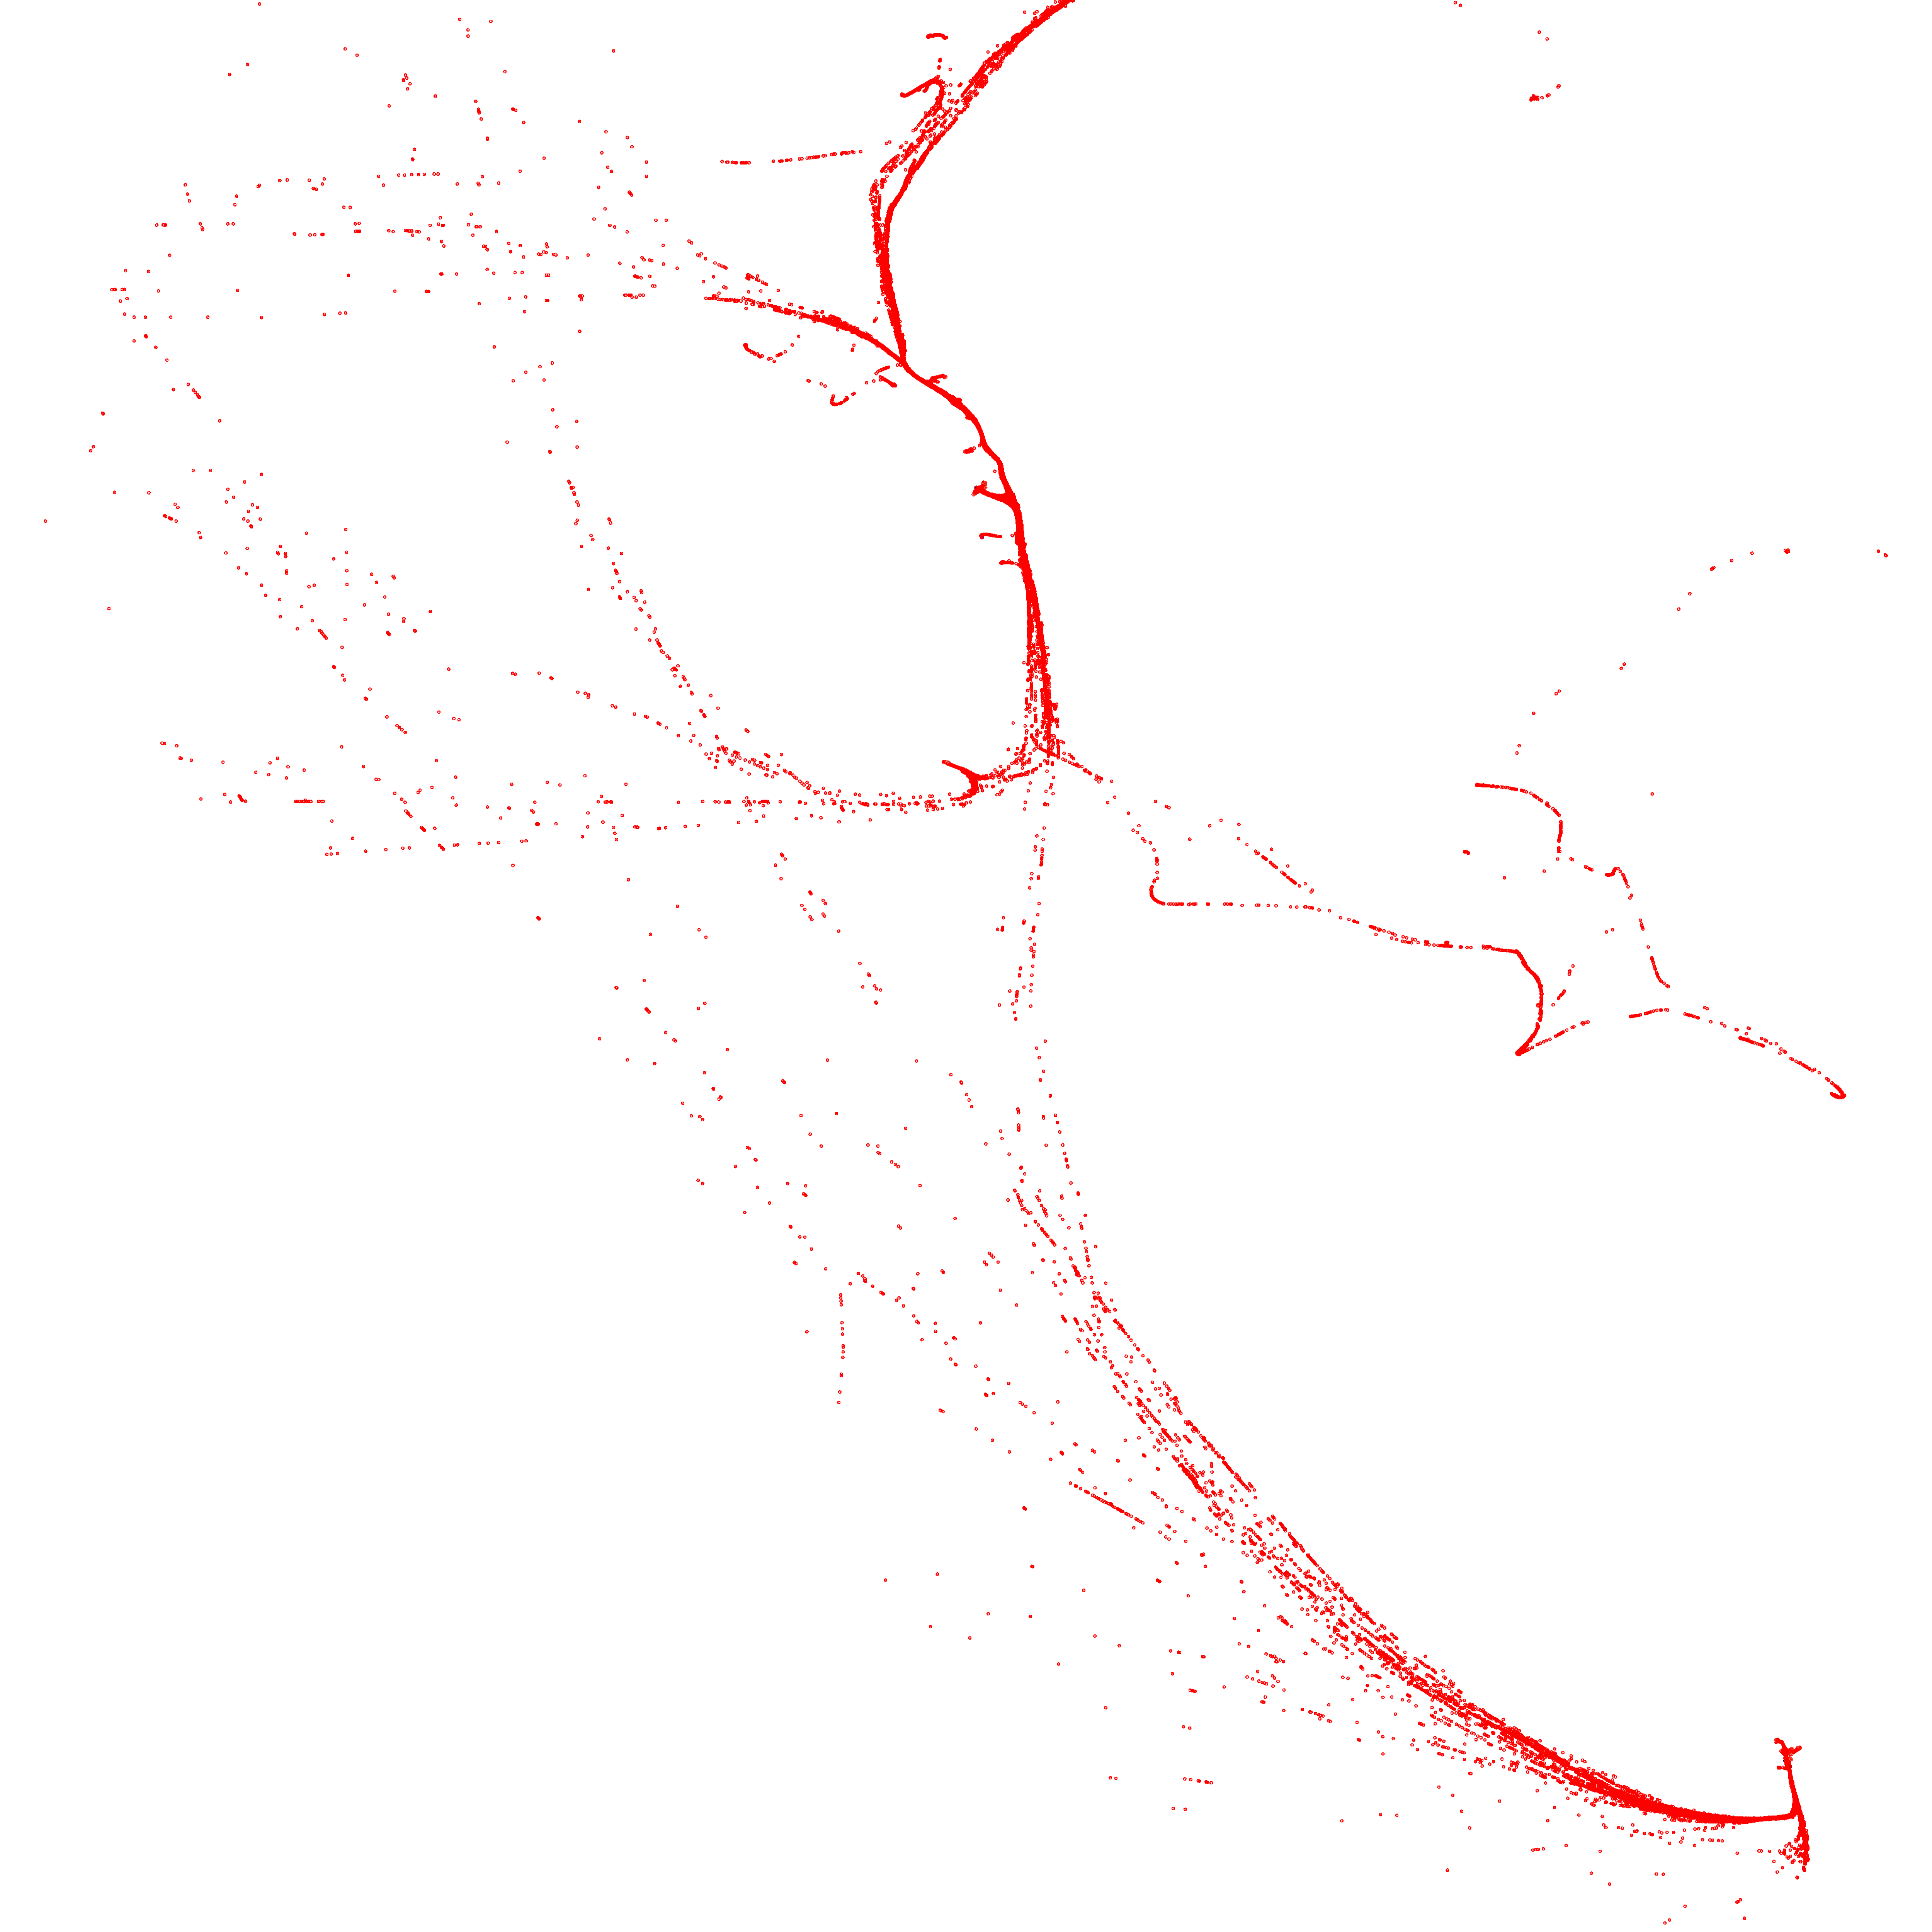
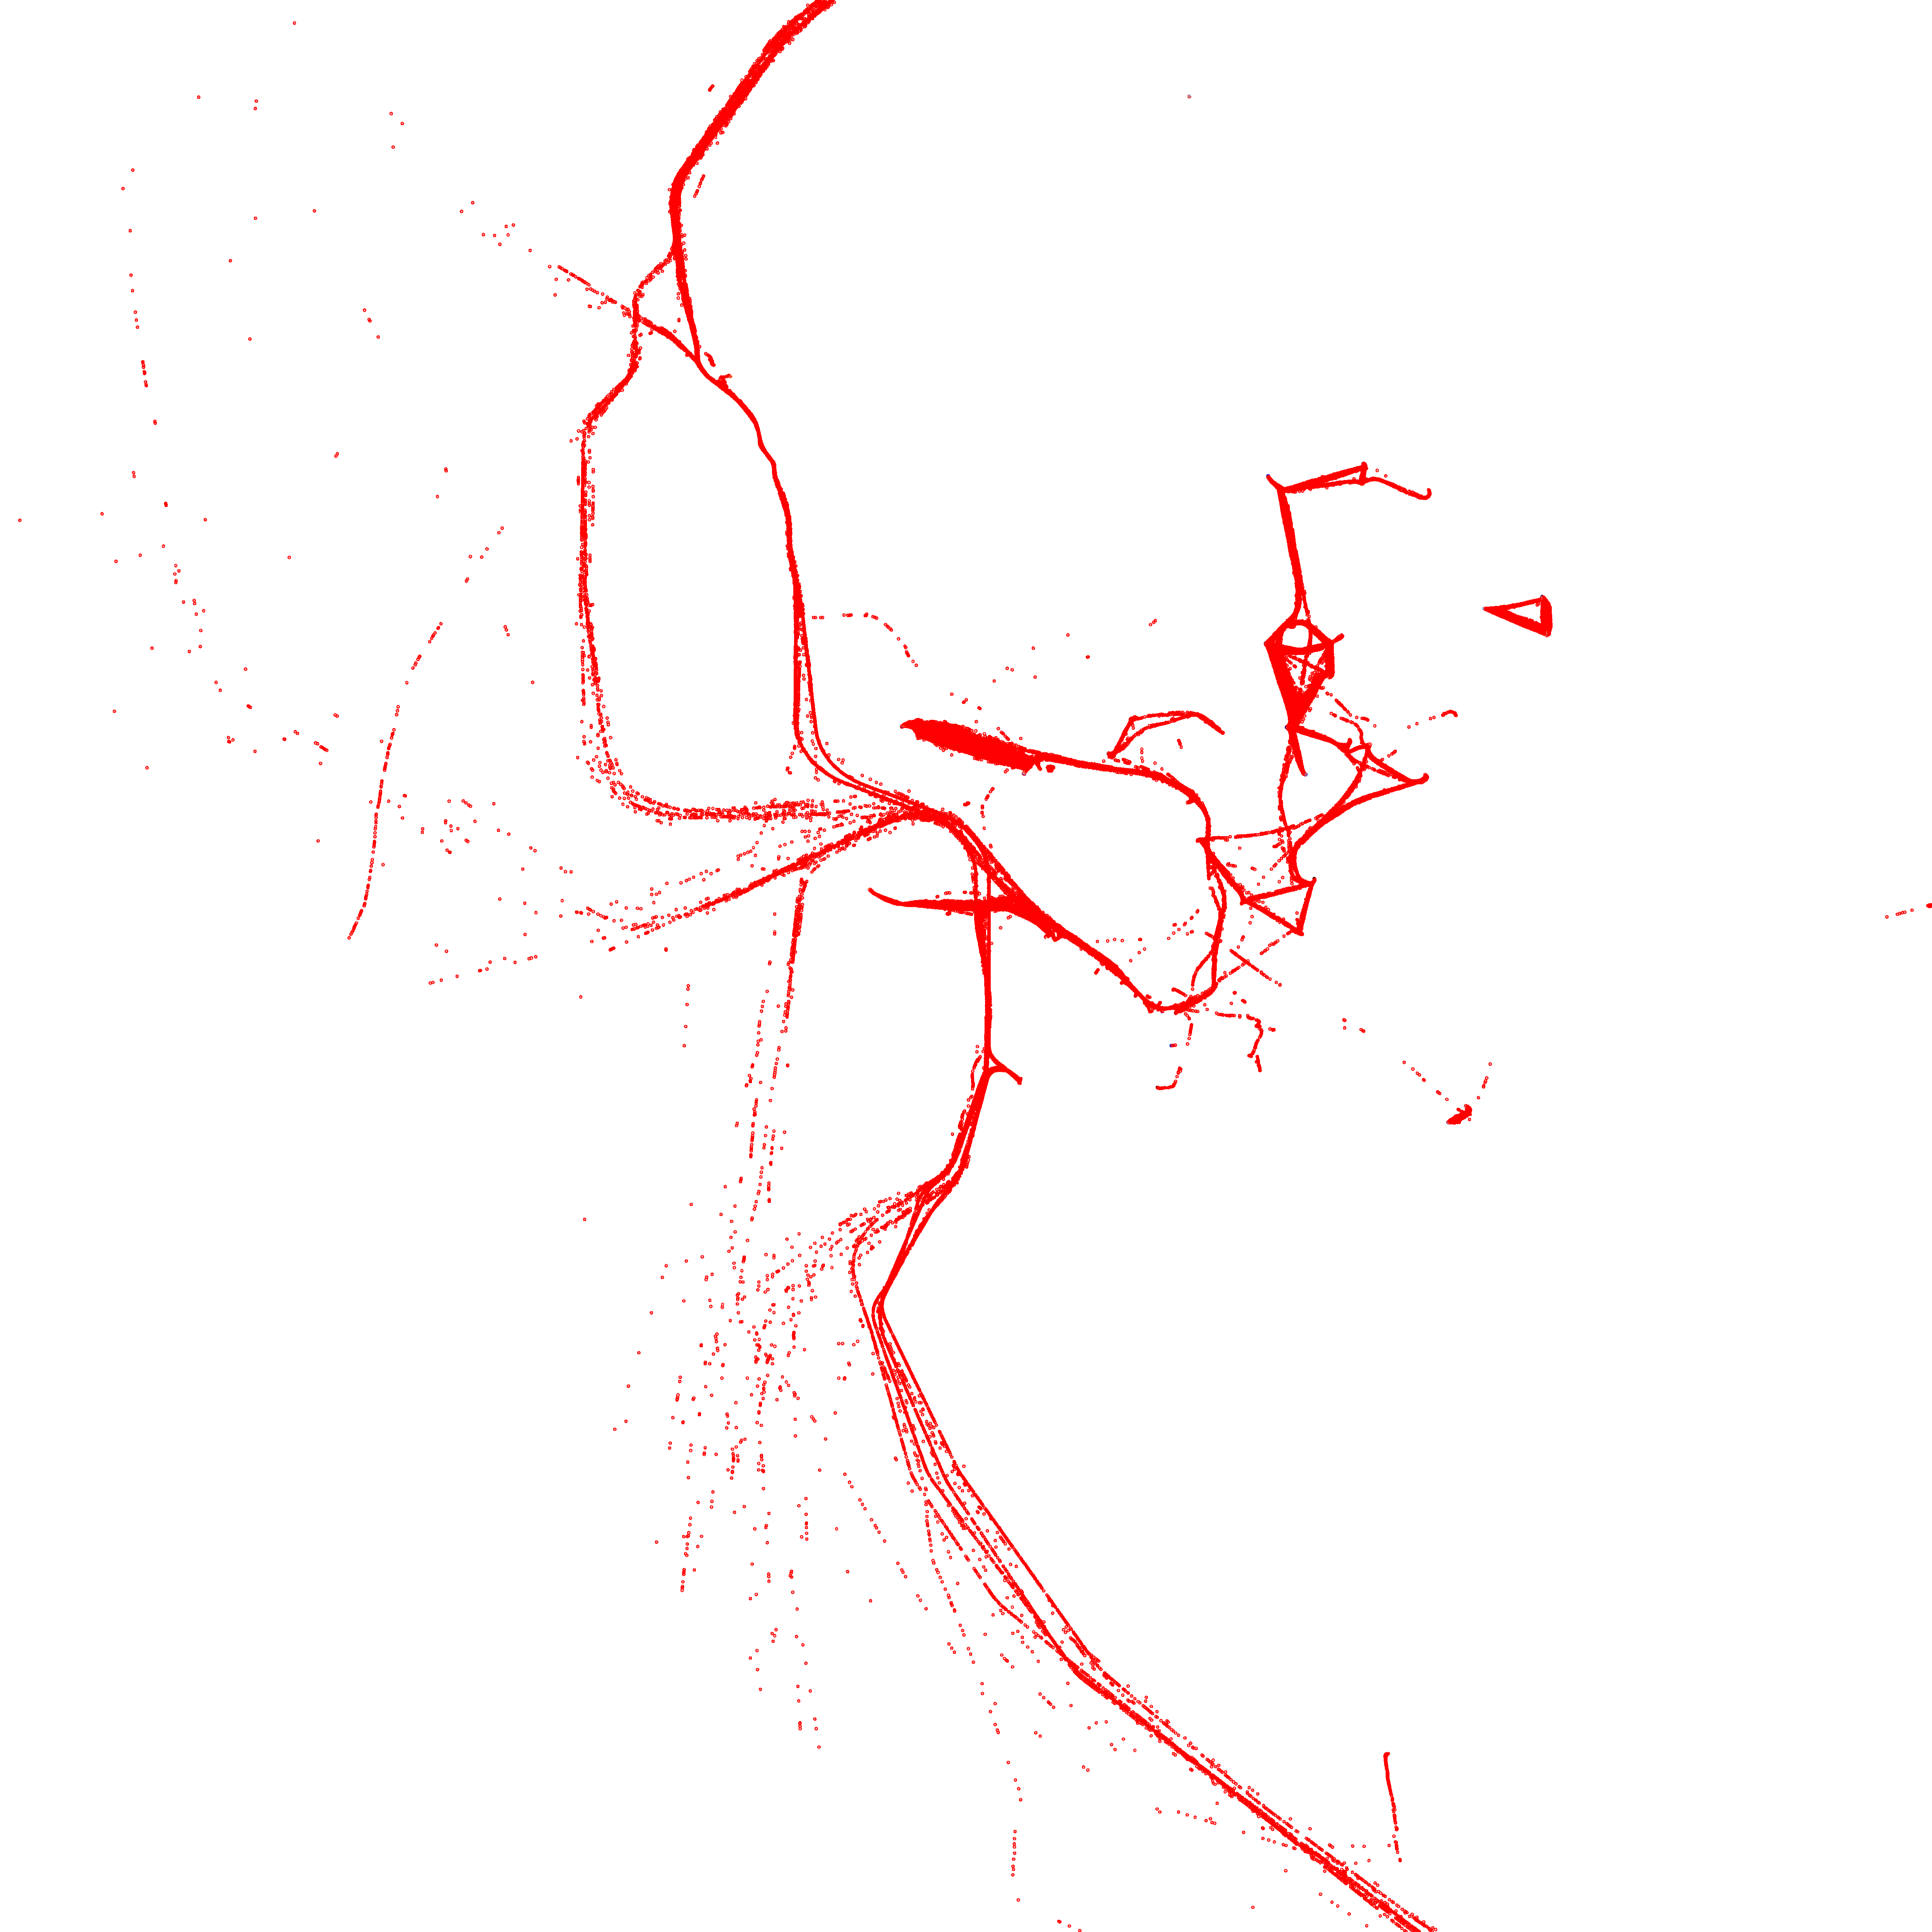
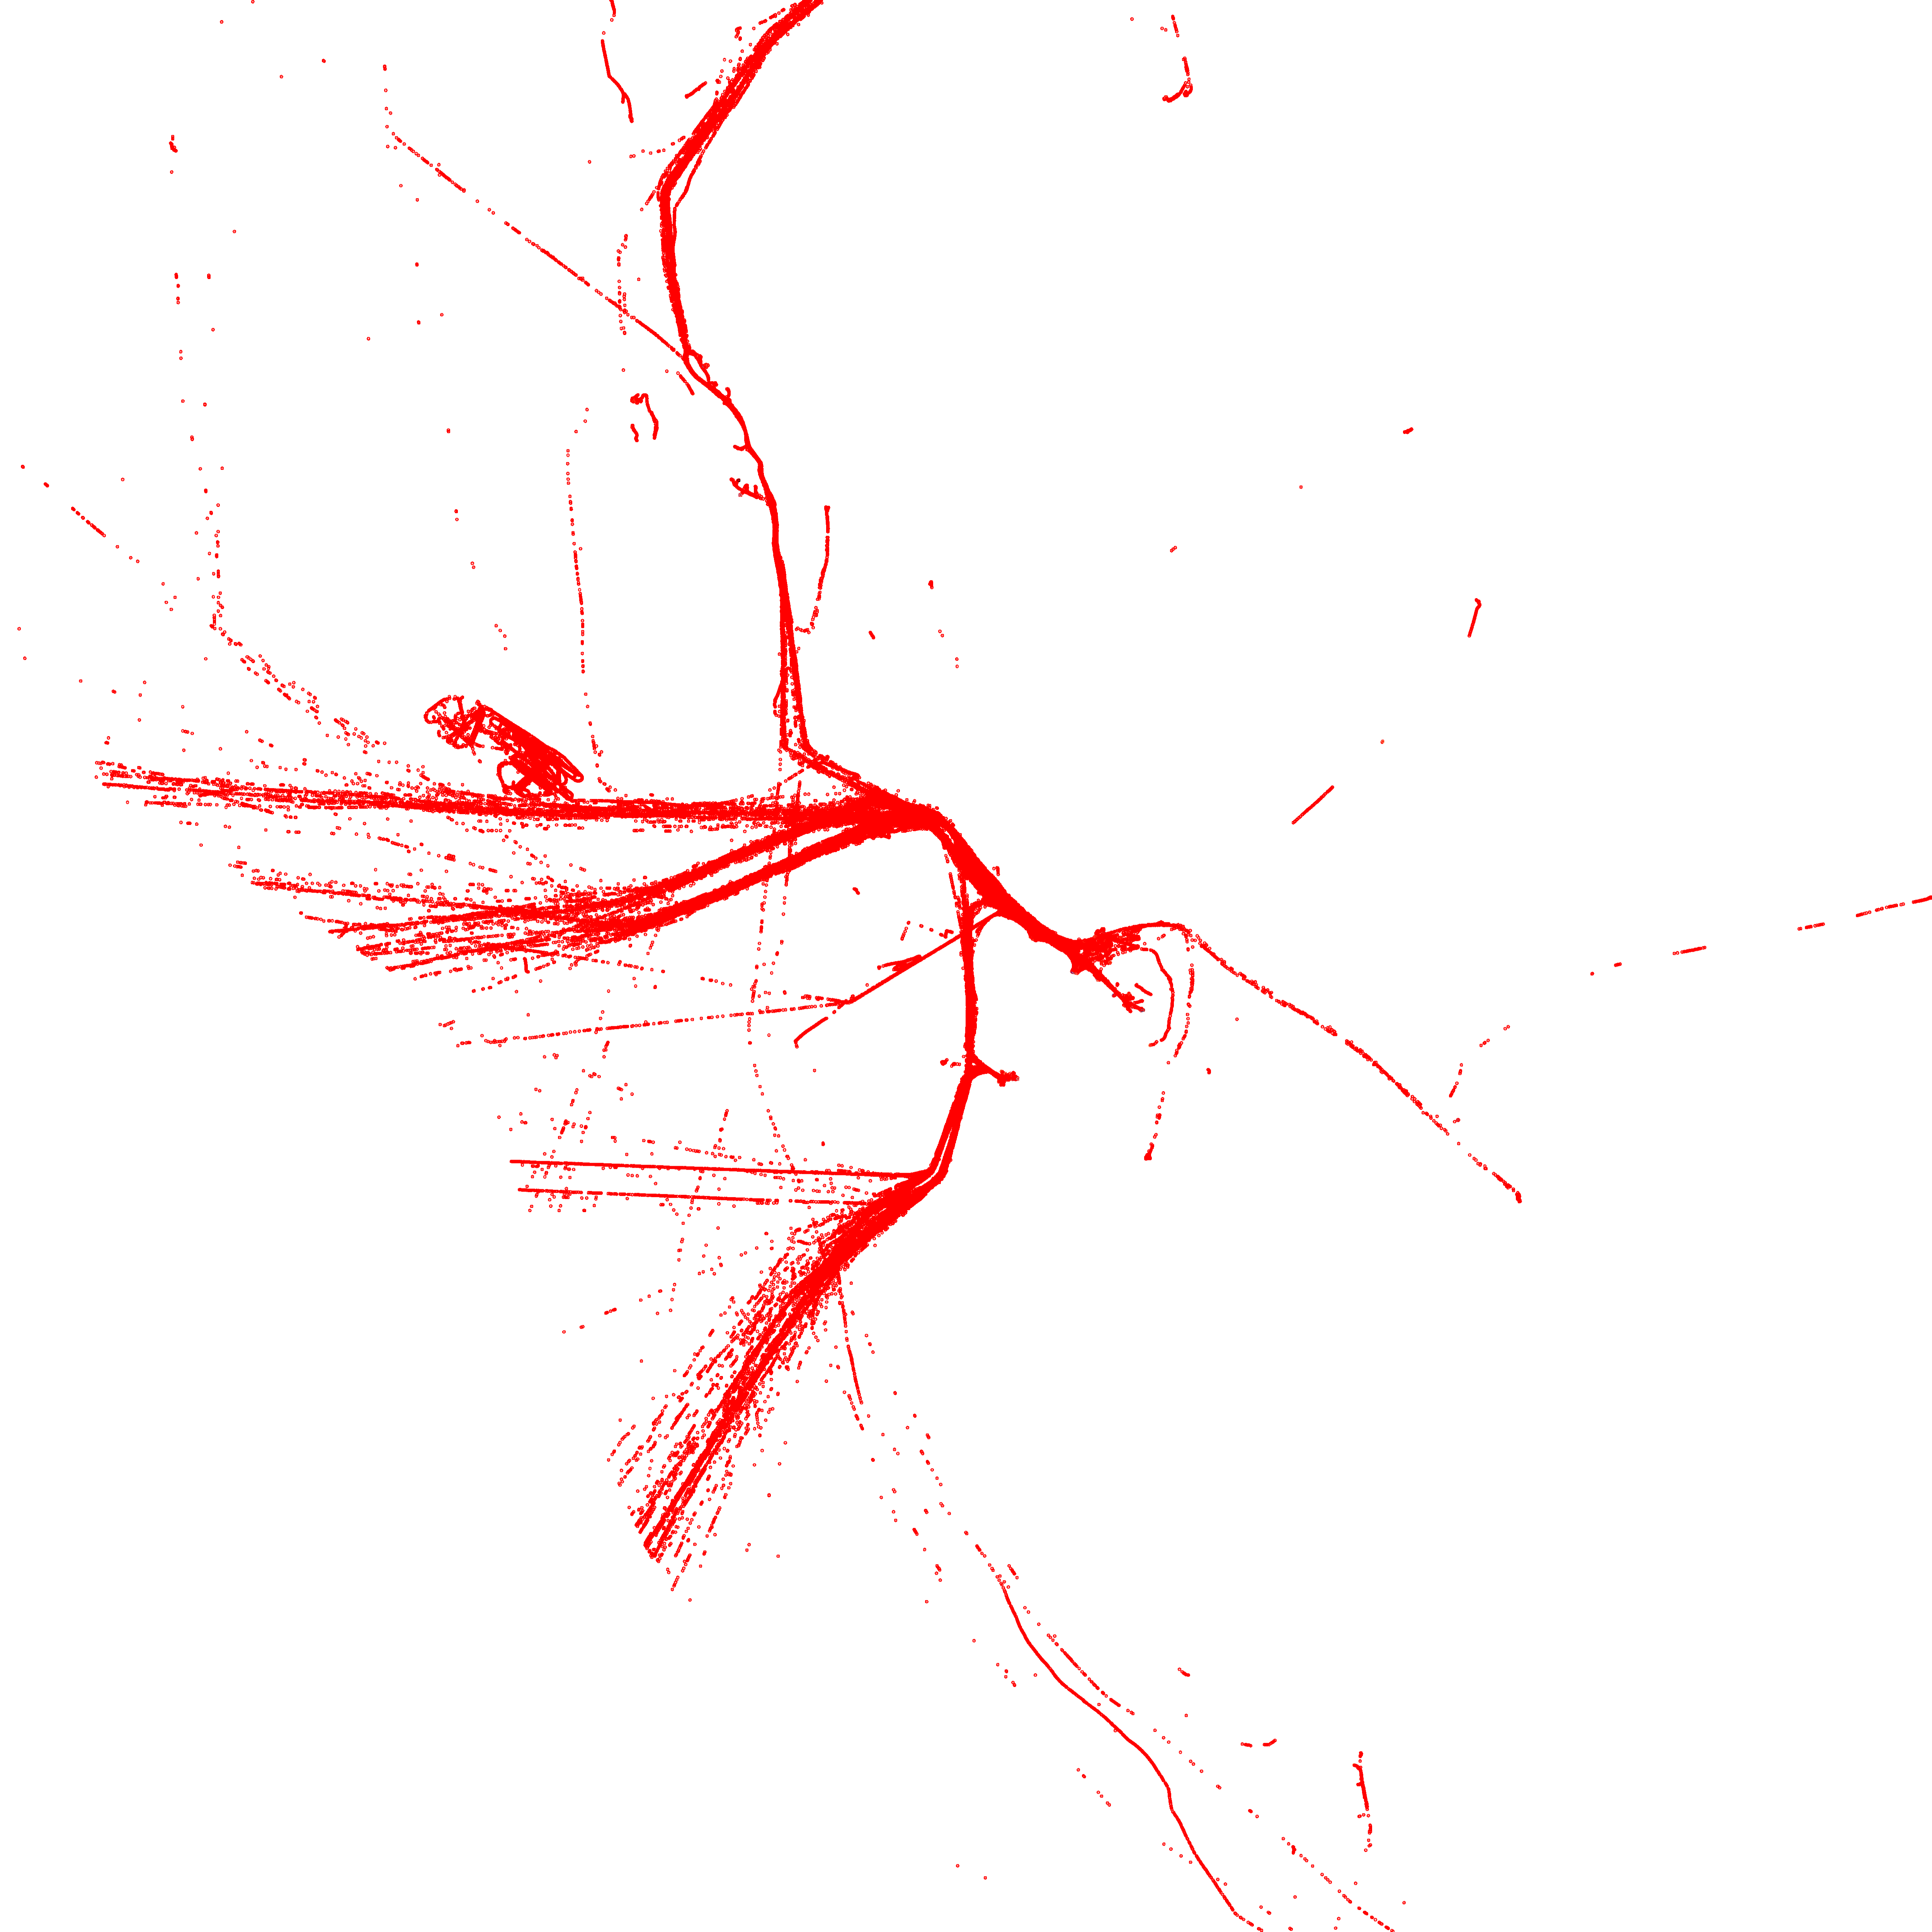

In [18]:
# make hexbin plots of different ship types
ship_types = ['Cargo', 'Fishing', 'Passenger', 'Auxiliary']
#ship_types = ['Passenger', 'Fishing']
gdf['skipsgruppe'] = gdf['skipsgruppe'].replace(to_replace=['Tug'], 
                                                value=['Auxiliary'])
map = folium.Map(location=[59, 5], tiles="OpenStreetMap", zoom_start=8)
for ship_type in ship_types:
    sub_gdf = gdf[gdf.skipsgruppe == ship_type]
    map=visualize.traffic_raster_overlay(sub_gdf, map, overlay_name=ship_type)
folium.LayerControl().add_to(map)
map.save('../reports/maps/raw_AIS_by_ship_category.html')
map


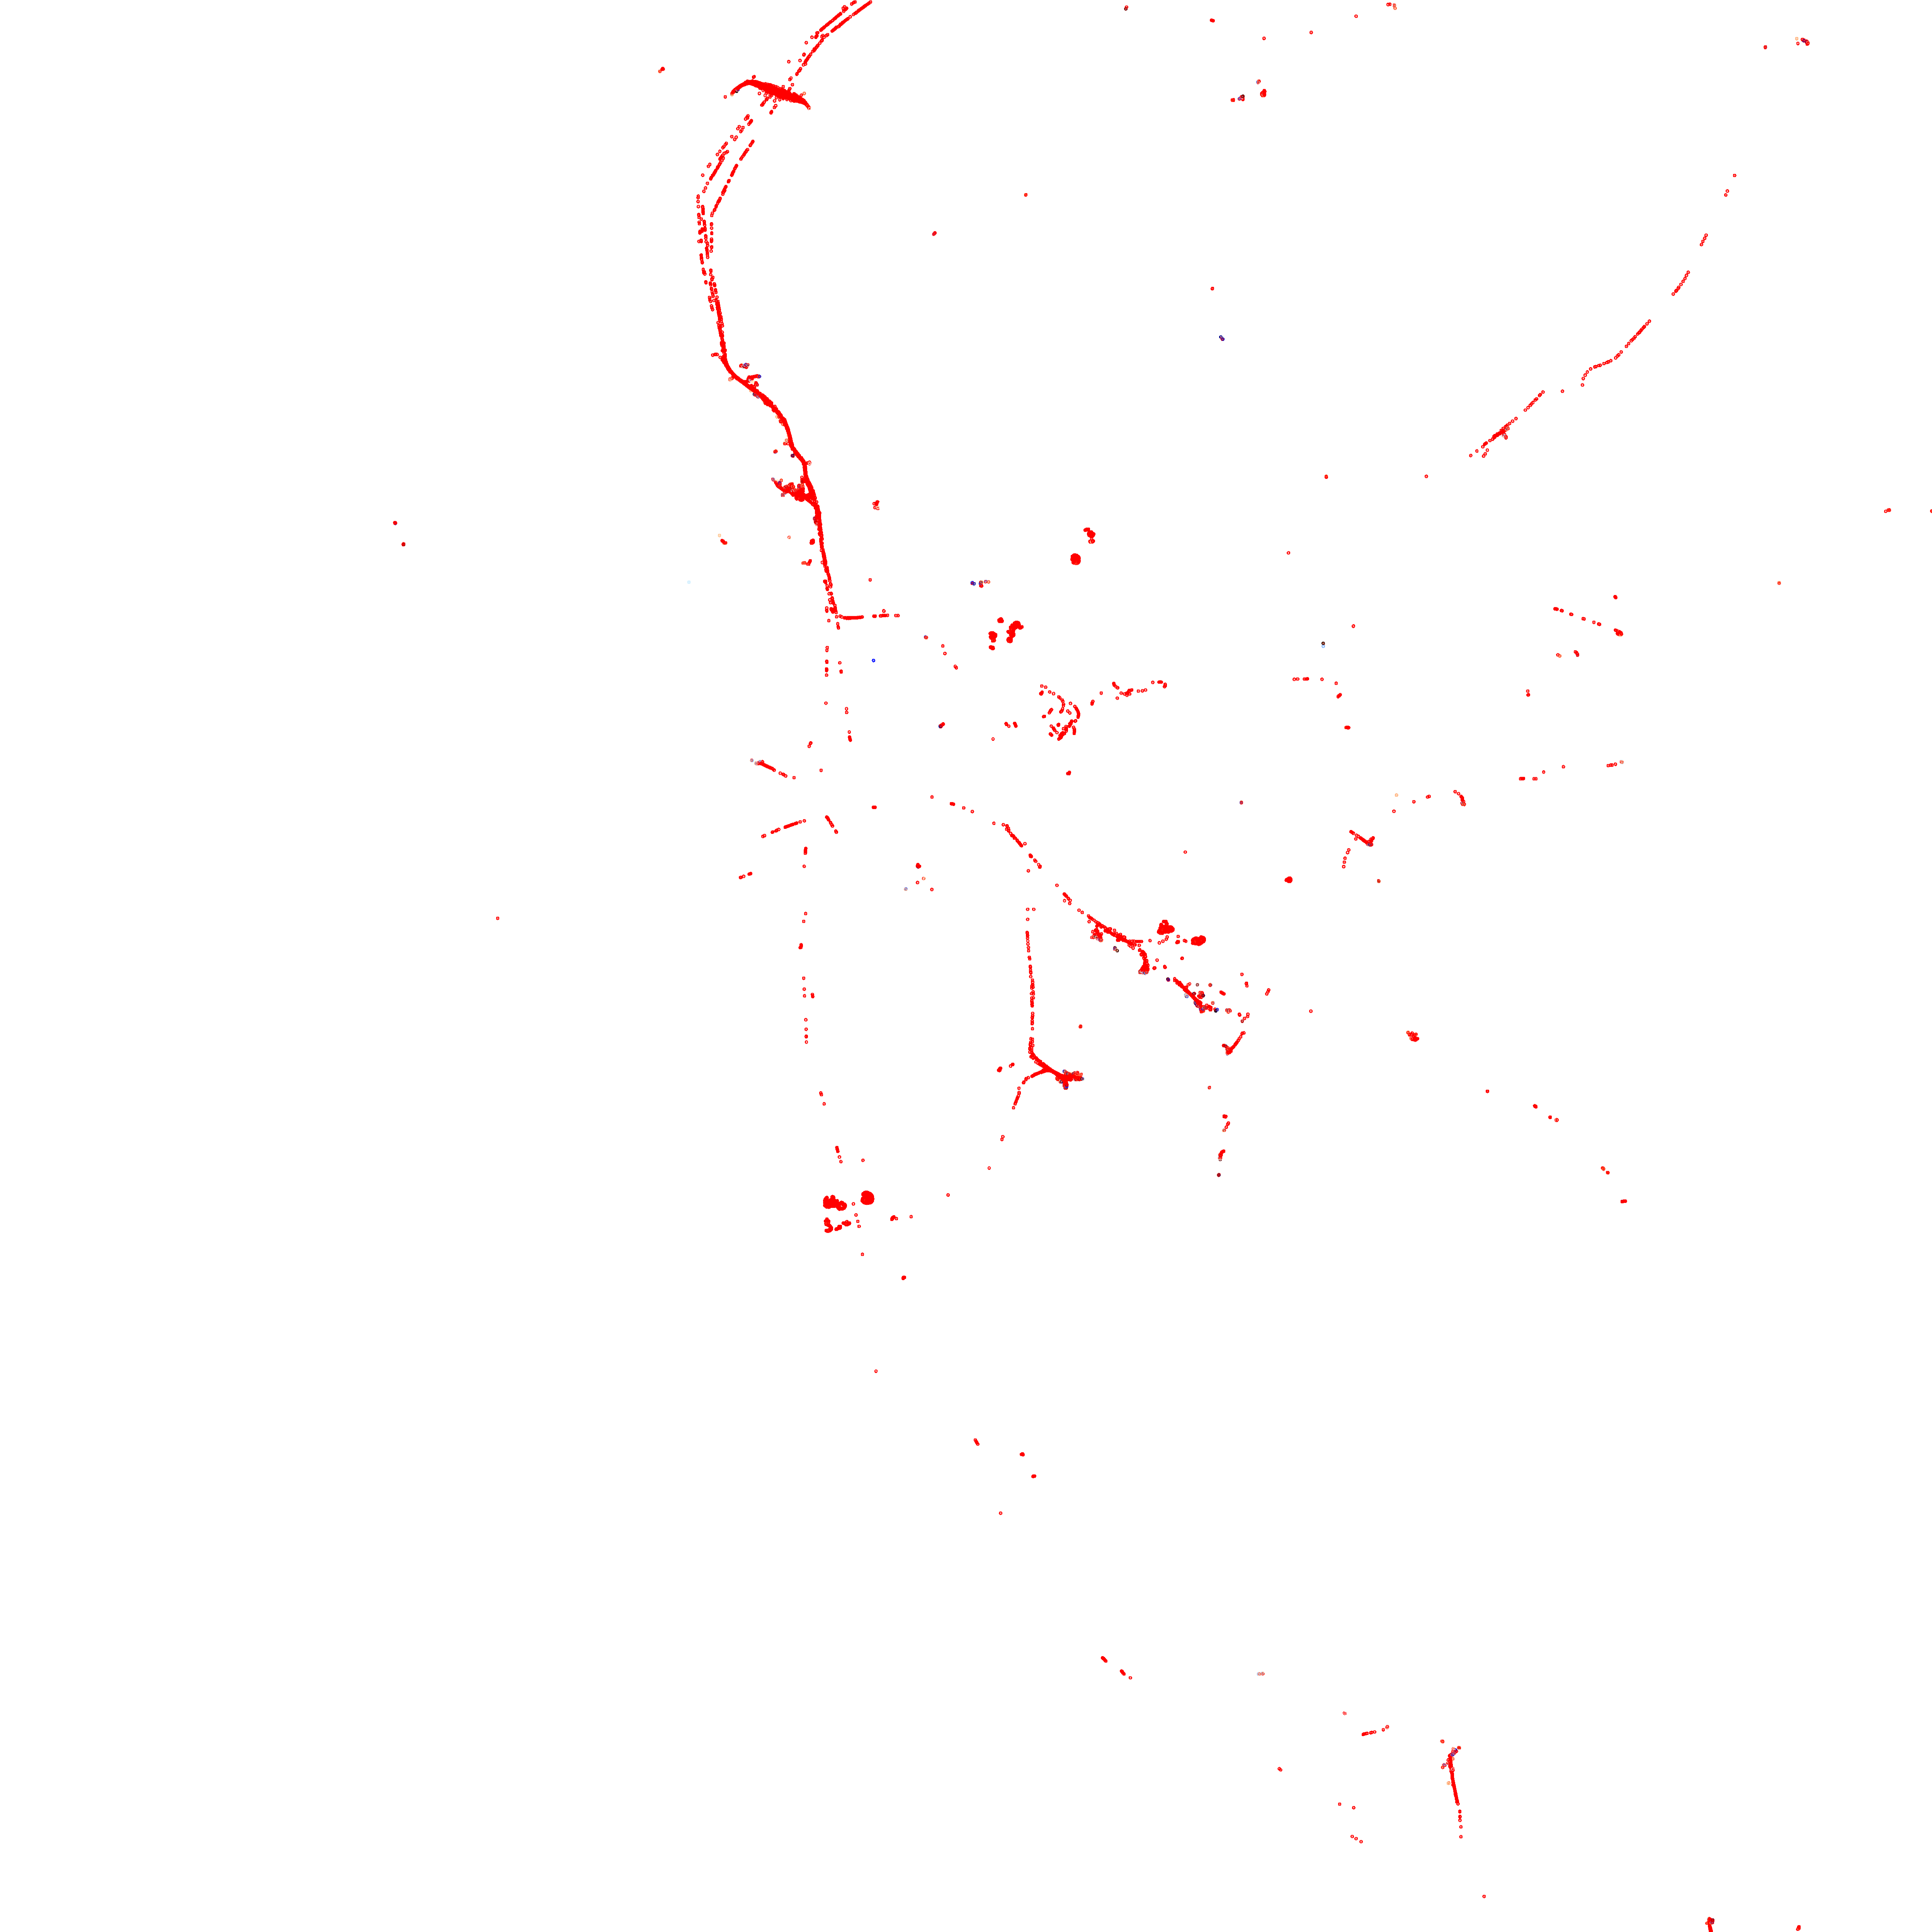

In [24]:
# map of stop points
map = folium.Map(location=[59, 5], tiles="OpenStreetMap", zoom_start=8)
sub_gdf = gdf[gdf.nav_status.isin([1, 5])]
map=visualize.traffic_raster_overlay(sub_gdf, map, overlay_name='ports and anchor places')
folium.LayerControl().add_to(map)
map.save('../reports/maps/stop_points.html')
map

In [19]:
import movingpandas as mpd
trajectories = mpd.TrajectoryCollection(gdf, traj_id_col='mmsi', 
                                        obj_id_col='mmsi', t='date_time_utc')

In [20]:
from datetime import timedelta, datetime
warnings.filterwarnings('ignore')
mmsis = gdf.mmsi.unique()
n=3
selection = mmsis[n:n+1]
#selection = [219347000]
selected_trajectories = trajectories.filter('mmsi', selection)
obs_split_trajectories = mpd.ObservationGapSplitter(selected_trajectories).split(gap=timedelta(minutes=10), min_length=500)
print(f'Observation Gap splitter split {len(trajectories)} trajectories into {len(obs_split_trajectories)} sub-trajectories')
# Split trajectories into sub trajectories when a stop longer than 30 seconds is observed (for example ferries). Only keep trajectories longer than 500m.
split_trajectories = mpd.StopSplitter(obs_split_trajectories).split(max_diameter=50, min_duration=timedelta(minutes=0.5), min_length=500)
print(f'Stop splitter split {len(obs_split_trajectories)} trajectories into {len(split_trajectories)} sub-trajectories')

map = split_trajectories.to_traj_gdf()[['geometry', 'mmsi']].explore(cmap='jet', column='mmsi', name='split trajectories', legend=False)
map = selected_trajectories.to_traj_gdf()[['geometry', 'mmsi']].explore(m=map, name='raw trajectories')
folium.LayerControl().add_to(map)
map

Observation Gap splitter split 658 trajectories into 2 sub-trajectories
Stop splitter split 2 trajectories into 5 sub-trajectories


In [21]:
map.save('../reports/maps/raw_trajectories.html')

In [22]:
patho_traj = split_trajectories.get_trajectory('231251000_0_2022-04-01 00:00:05')
map = patho_traj.to_traj_gdf()[['geometry', 'mmsi']].explore(color='blue', name='split trajectories', legend=False)
map = patho_traj.to_point_gdf().reset_index()[['geometry', 'mmsi']].explore(m=map, color='blue', name='split trajectories', legend=False, marker_kwds={'radius':6, 'opacity':1})
map

AttributeError: 'NoneType' object has no attribute 'to_traj_gdf'